In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sys import path
path.append('..')
from statistical_clear_sky.algorithm.iterative_fitting import IterativeFitting
from statistical_clear_sky.solver_type import SolverType
from statistical_clear_sky.utilities.data_conversion import make_time_series
from statistical_clear_sky.utilities.filters import lowpass_2d
import s3fs
import cvxpy as cvx
import pandas as pd
import numpy as np
from numpy.fft import fft2, fftshift
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='darkgrid', palette='colorblind')
%matplotlib inline
PLOT_ARGS = {
    'linewidth': 1,
    'figsize': (12,8)
}
TZ_LOOKUP = {
    'America/Anchorage': 9,
    'America/Chicago': 6,
    'America/Denver': 7,
    'America/Los_Angeles': 8,
    'America/New_York': 5,
    'America/Phoenix': 7,
    'Pacific/Honolulu': 10
}
from datetime import datetime

In [3]:
def load_sys(n, local=True):
    if local:
        base = '../data/PVO/'
    if not local:
        base = 's3://pvinsight.nrel/PVO/'
    meta = pd.read_csv('../data/PVO/sys_meta.csv')
    id = meta['ID'][n]
    df = pd.read_csv(base+'PVOutput/{}.csv'.format(id), index_col=0,
                      parse_dates=[0], usecols=[1, 3])
    tz = meta['TimeZone'][n]
    df.index = df.index.tz_localize(tz).tz_convert('Etc/GMT+{}'.format(TZ_LOOKUP[tz]))   # fix daylight savings
    start = df.index[0]
    end = df.index[-1]
    time_index = pd.date_range(start=start, end=end, freq='5min')
    df = df.reindex(index=time_index, fill_value=0)
    print(n, id)
    return df

In [4]:
df = load_sys(200, local=False)

200 21167


In [5]:
days = df.resample('D').max().index[1:-1]
start = days[0]
end = days[-1]
print(start.date(), end.date())

2013-08-05 2017-07-30


In [6]:
end - start

Timedelta('1455 days 00:00:00')

In [7]:
power_signals_d = df.loc[start:end].iloc[:-1].values.reshape(288, -1, order='F')
iterative_fitting = IterativeFitting(power_signals_d, rank_k=4, auto_fix_time_shifts=False, solver_type=SolverType.mosek)

In [8]:
print(iterative_fitting.fixed_time_stamps)

False


obtaining weights


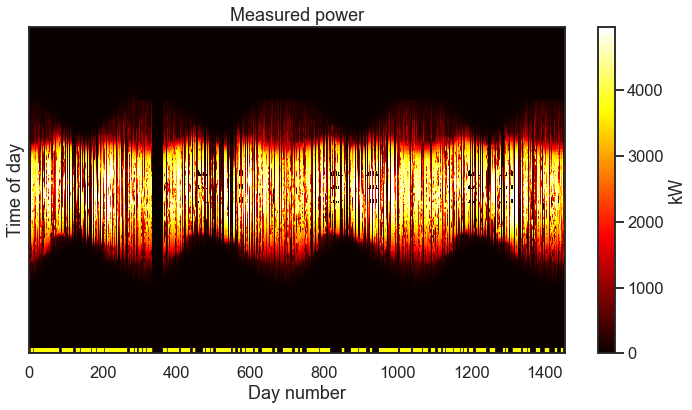

In [15]:
_ = iterative_fitting.plot_power_signals_d(show_days=True)

In [16]:
iterative_fitting = IterativeFitting(power_signals_d, rank_k=4, solver_type=SolverType.mosek)

In [17]:
print(iterative_fitting.fixed_time_stamps)

True


obtaining weights


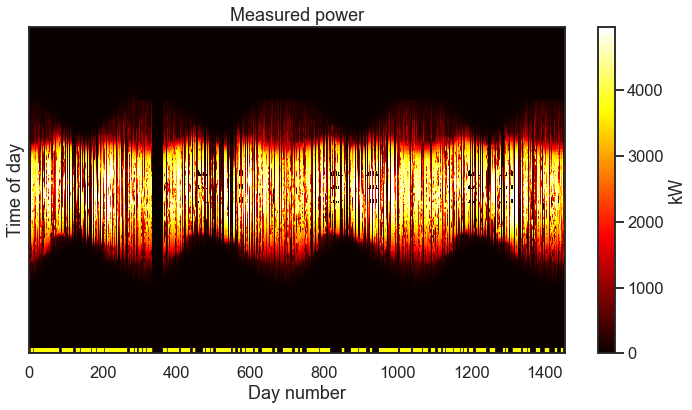

In [18]:
_ = iterative_fitting.plot_power_signals_d(show_days=True)

/Users/tadatoshi/.pyenv/versions/anaconda3-2018.12/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


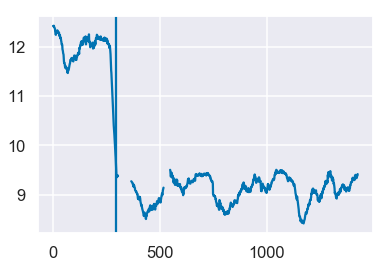

In [19]:
w = 30
sc = 20
s1 = np.convolve(np.divide(np.dot(np.linspace(0, 24, power_signals_d.shape[0]), power_signals_d), np.sum(power_signals_d, axis=0)), np.ones(w), mode='valid') / w
plt.plot(range(len(s1)), s1)
plt.axvline(293)

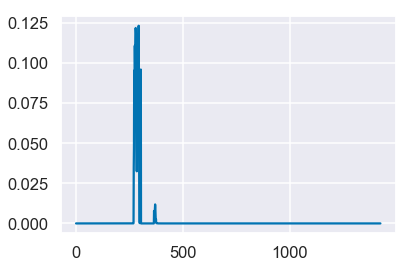

In [20]:
x = cvx.Variable(len(s1))
mu = cvx.Constant(10)
obj = cvx.Minimize(cvx.norm(s1[np.isfinite(s1)] - x[np.isfinite(s1)]) + mu * cvx.norm1(x[:-1] - x[1:]))
prob = cvx.Problem(obj)
prob.solve(solver='MOSEK')
s2 = x.value[:-1] - x.value[1:]
plt.plot(range(len(s2)), s2)

In [21]:
from statistical_clear_sky.utilities.filters import edge_find_1d
from statistical_clear_sky.algorithm.utilities.time_shifts import fix_time_shifts

In [22]:
edge_find_1d(s1)

[282]

2 segments found
index locations:  [297]


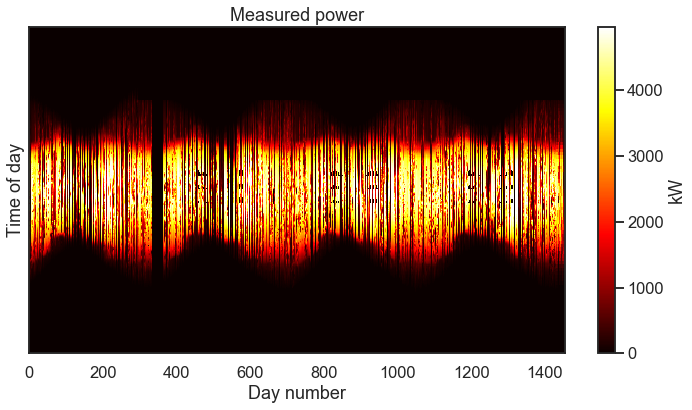

In [23]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=1, figsize=(12,6), sharex=True)
    foo = ax.imshow(fix_time_shifts(power_signals_d, verbose=True), cmap='hot', interpolation='none', aspect='auto')
    #plt.colorbar(label='kW')
    ax.set_title('Measured power')
    plt.colorbar(foo, ax=ax, label='kW')
    ax.set_xlabel('Day number')
    ax.set_yticks([])
    ax.set_ylabel('Time of day')

/Users/tadatoshi/.pyenv/versions/anaconda3-2018.12/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


[275, 986]


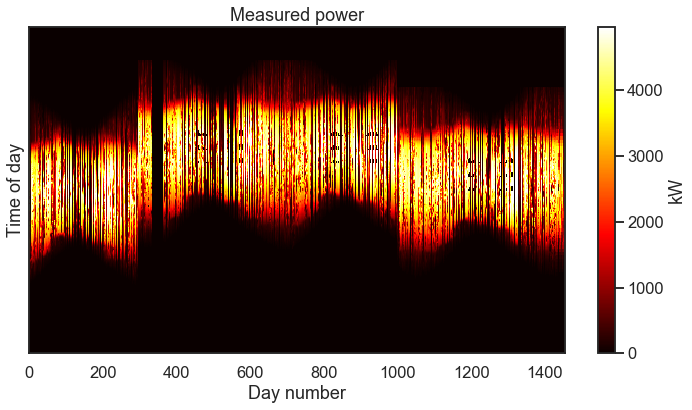

In [25]:
power_signals_d_roll = np.roll(power_signals_d, 2*12, axis=0)
power_signals_d_prime = np.copy(power_signals_d)
power_signals_d_prime[:, 1000:] = power_signals_d_roll[:, 1000:]

w = 30
s1 = np.convolve(np.divide(np.dot(np.linspace(0, 24, power_signals_d_prime.shape[0]), power_signals_d_prime), np.sum(power_signals_d_prime, axis=0)), np.ones(w), mode='valid') / w
ixs = edge_find_1d(s1, tol=1e-1)
print(ixs)
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=1, figsize=(12,6), sharex=True)
    foo = ax.imshow(power_signals_d_prime[:, :], cmap='hot', interpolation='none', aspect='auto')
    #plt.colorbar(label='kW')
    ax.set_title('Measured power')
    plt.colorbar(foo, ax=ax, label='kW')
    ax.set_xlabel('Day number')
    ax.set_yticks([])
    ax.set_ylabel('Time of day')

3 segments found
index locations:  [290, 1001]


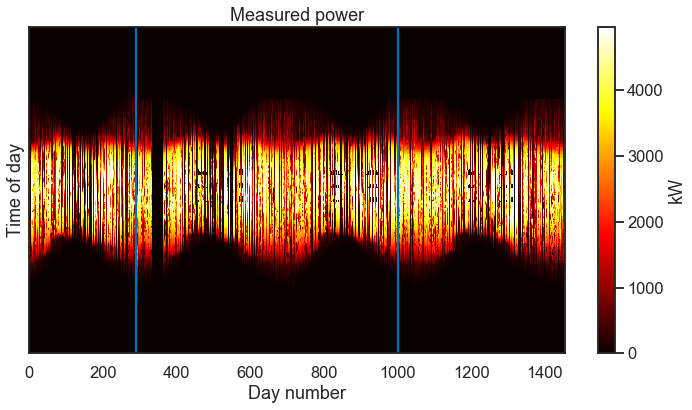

In [26]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=1, figsize=(12,6), sharex=True)
    foo = ax.imshow(fix_time_shifts(power_signals_d_prime[:, :], verbose=True), cmap='hot', interpolation='none', aspect='auto')
    #plt.colorbar(label='kW')
    ax.set_title('Measured power')
    plt.colorbar(foo, ax=ax, label='kW')
    ax.set_xlabel('Day number')
    ax.set_yticks([])
    ax.set_ylabel('Time of day')
    for i in ixs:
        ax.axvline(i + w/2)

In [27]:
u, sig, vt = np.linalg.svd(power_signals_d, full_matrices=False)
u[:, 0] *= -1
vt[0] *= -1

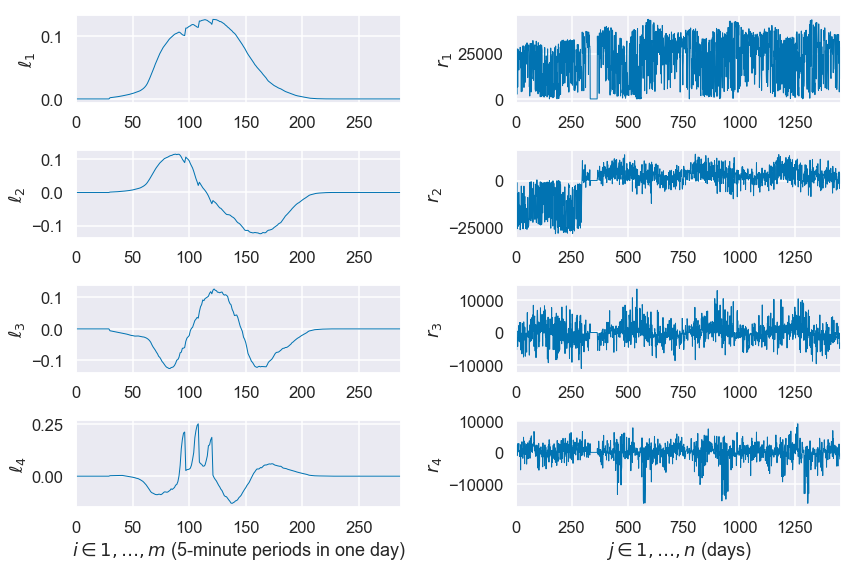

In [28]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12,8))
for i in range(4):
    ax[i][0].plot(u.T[i], linewidth=1)
    ax[i][0].set_xlim(0, 287)
    ax[i][0].set_ylabel('$\\ell_{}$'.format(i+1))
    ax[i][1].plot((np.diag(sig).dot(vt))[i], linewidth=1)
    ax[i][1].set_xlim(0, power_signals_d.shape[1])
    ax[i][1].set_ylabel('$r_{}$'.format(i+1))
ax[-1][0].set_xlabel('$i \\in 1, \\ldots, m$ (5-minute periods in one day)')
ax[-1][1].set_xlabel('$j \\in 1, \\ldots, n$ (days)')
plt.tight_layout()
plt.show()

In [29]:
iterative_fitting = IterativeFitting(power_signals_d, rank_k=4, solver_type=SolverType.mosek)

In [30]:
import cvxpy as cvx
try:
    iterative_fitting.execute(mu_l=1e5, mu_r=1e3, tau=0.9, max_iteration=10, exit_criterion_epsilon=5e-3, 
                              max_degradation=None, min_degradation=None)
except cvx.SolverError:
    print('solver failed!')

obtaining initial value of component r0
obtaining weights
starting at 1527229762.555 [35136685.101446204, 47812.05083990624, 1073922330.3366718, 418122935.0659721]
Miminizing left L matrix
Miminizing right R matrix
iteration 1: 2441095.557 [2.21834173e+06 3.23679900e+03 2.19515446e+05 1.58300000e+00]
Miminizing left L matrix
Miminizing right R matrix
iteration 2: 1891555.287 [1.66032690e+06 4.18575600e+03 2.27042601e+05 3.40000000e-02]
Miminizing left L matrix
Miminizing right R matrix
iteration 3: 1867209.367 [1.63373325e+06 4.42010700e+03 2.29055979e+05 2.60000000e-02]
Miminizing left L matrix
Miminizing right R matrix
iteration 4: 1855246.310 [1.62257730e+06 4.59823700e+03 2.28070655e+05 1.17000000e-01]
Miminizing left L matrix
Miminizing right R matrix
iteration 5: 1845303.545 [1.61495123e+06 4.55449200e+03 2.25797674e+05 1.50000000e-01]
Miminizing left L matrix
Miminizing right R matrix
iteration 6: 1836027.242 [1.60723229e+06 4.73561900e+03 2.24059269e+05 6.10000000e-02]
Miminizi

In [31]:
clearsky = iterative_fitting.clear_sky_signals()
m = clearsky != 0
residuals = np.divide(clearsky[m] - iterative_fitting.power_signals_d[m], clearsky[m])
print(np.linalg.norm(residuals))

16365.995304103619


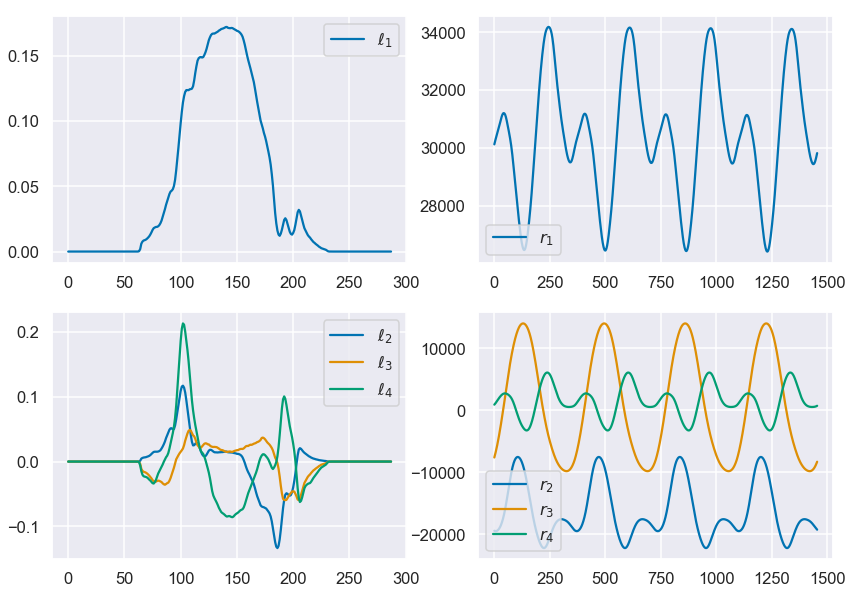

In [32]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
ax[0, 1].plot(iterative_fitting.r_cs_value[0])
ax[1, 1].plot(iterative_fitting.r_cs_value[1:].T)
ax[0, 0].plot(iterative_fitting.l_cs_value[:, 0])
ax[1, 0].plot(iterative_fitting.l_cs_value[:, 1:])
ax[0, 0].legend(['$\\ell_1$'])
ax[1, 0].legend(['$\\ell_{}$'.format(ix) for ix in range(2, iterative_fitting.r_cs_value.shape[0]+1)])
ax[0, 1].legend(['$r_{1}$'])
ax[1, 1].legend(['$r_{}$'.format(ix) for ix in range(2, iterative_fitting.r_cs_value.shape[0]+1)])
plt.show()

Here is the estimated degradation rate (year on year energy-yield) for the system:

In [33]:
iterative_fitting.beta_value

array(-0.00067905)

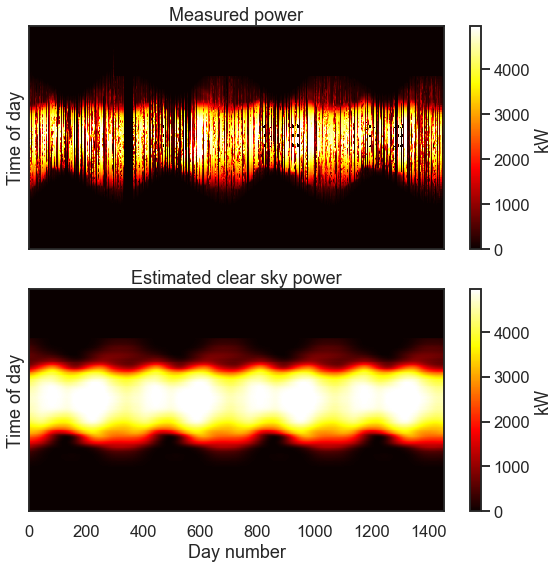

In [34]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=2, figsize=(8,8), sharex=True)
    foo = ax[0].imshow(iterative_fitting.power_signals_d, cmap='hot', interpolation='none', aspect='auto')
    #plt.colorbar(label='kW')
    ax[0].set_title('Measured power')
    bar = ax[1].imshow(iterative_fitting.clear_sky_signals(), cmap='hot',
                       vmin=0, vmax=np.max(iterative_fitting.power_signals_d), interpolation='none', aspect='auto')
    ax[1].set_title('Estimated clear sky power')
    plt.colorbar(foo, ax=ax[0], label='kW')
    plt.colorbar(bar, ax=ax[1], label='kW')
    ax[1].set_xlabel('Day number')
    ax[0].set_yticks([])
    ax[0].set_ylabel('Time of day')
    ax[1].set_yticks([])
    ax[1].set_ylabel('Time of day')
    plt.tight_layout()

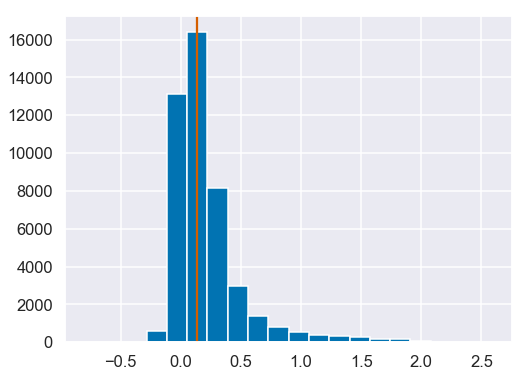

0.13641409648829614 0.31680127310653705


In [35]:
# scale residuals by daily weight, which sets many days to zero. 
w1 = np.diag(iterative_fitting.weights)
wres = np.dot(iterative_fitting.clear_sky_signals() - iterative_fitting.power_signals_d, w1)
use_days = np.logical_not(np.isclose(np.sum(wres, axis=0), 0))
scaled_wres = wres[:, use_days] / np.average(iterative_fitting.power_signals_d[:, use_days])
final_metric = scaled_wres[iterative_fitting.power_signals_d[:, use_days] > 1e-3]
plt.figure(figsize=(8,6))
plt.hist(final_metric, bins=20)
plt.axvline(np.percentile(final_metric, 50), color='r')
plt.show()
print(np.percentile(final_metric, 50), np.std(final_metric))

In [36]:
iterative_fitting = IterativeFitting(fix_time_shifts(power_signals_d, verbose=True), rank_k=4, solver_type=SolverType.mosek)

2 segments found
index locations:  [297]


In [37]:
import cvxpy as cvx
try:
    iterative_fitting.execute(mu_l=1e5, mu_r=1e3, tau=0.9, max_iteration=10, exit_criterion_epsilon=5e-3, 
                              max_degradation=None, min_degradation=None)
except cvx.SolverError:
    print('solver failed!')

obtaining initial value of component r0
obtaining weights
starting at 1330548902.361 [3793555.0219395254, 60510.06667423659, 1084859854.556257, 241834982.7160453]
Miminizing left L matrix
Miminizing right R matrix
iteration 1: 2108528.204 [1.93956078e+06 2.64554700e+03 1.66321610e+05 2.68000000e-01]
Miminizing left L matrix
Miminizing right R matrix
iteration 2: 1801867.850 [1.6317176e+06 6.2179510e+03 1.6393217e+05 1.3200000e-01]
Miminizing left L matrix
Miminizing right R matrix
iteration 3: 1772574.785 [1.60107415e+06 6.02482000e+03 1.65475598e+05 2.16000000e-01]
Miminizing left L matrix
Miminizing right R matrix
iteration 4: 1758677.273 [1.58646158e+06 6.08475700e+03 1.66130908e+05 2.80000000e-02]
Miminizing left L matrix
Miminizing right R matrix
iteration 5: 1750744.920 [1.57807959e+06 6.44074200e+03 1.66224472e+05 1.19000000e-01]
Minimization complete in 3.41 minutes


In [38]:
clearsky = iterative_fitting.clear_sky_signals()
m = clearsky != 0
residuals = np.divide(clearsky[m] - iterative_fitting.power_signals_d[m], clearsky[m])
print(np.linalg.norm(residuals))

21856.400992551913


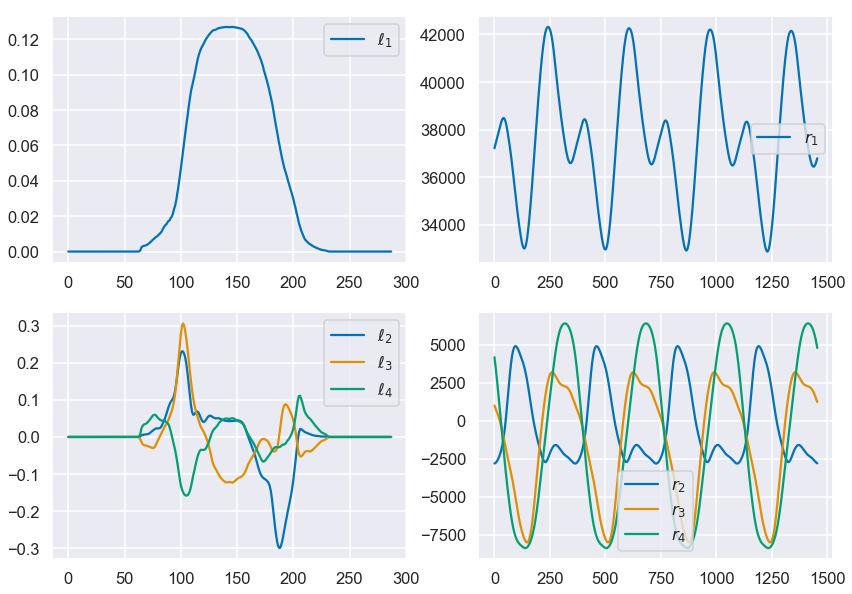

In [39]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
ax[0, 1].plot(iterative_fitting.r_cs_value[0])
ax[1, 1].plot(iterative_fitting.r_cs_value[1:].T)
ax[0, 0].plot(iterative_fitting.l_cs_value[:, 0])
ax[1, 0].plot(iterative_fitting.l_cs_value[:, 1:])
ax[0, 0].legend(['$\\ell_1$'])
ax[1, 0].legend(['$\\ell_{}$'.format(ix) for ix in range(2, iterative_fitting.r_cs_value.shape[0]+1)])
ax[0, 1].legend(['$r_{1}$'])
ax[1, 1].legend(['$r_{}$'.format(ix) for ix in range(2, iterative_fitting.r_cs_value.shape[0]+1)])
plt.show()

Here is the estimated degradation rate (year on year energy-yield) for the system:

In [40]:
iterative_fitting.beta_value

array(-0.00131456)

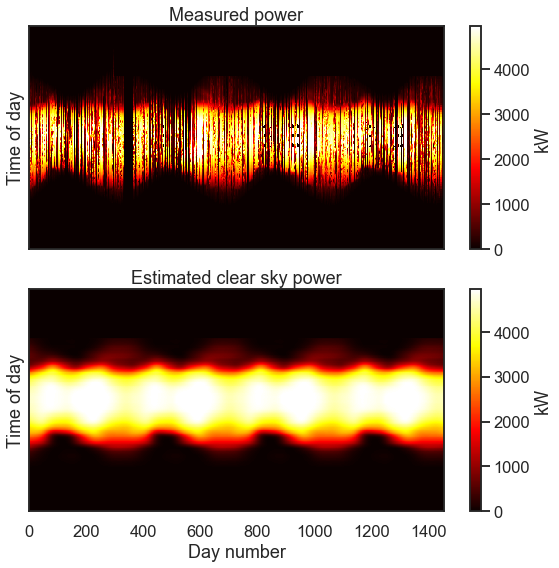

In [41]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=2, figsize=(8,8), sharex=True)
    foo = ax[0].imshow(iterative_fitting.power_signals_d, cmap='hot', interpolation='none', aspect='auto')
    #plt.colorbar(label='kW')
    ax[0].set_title('Measured power')
    bar = ax[1].imshow(iterative_fitting.clear_sky_signals(), cmap='hot',
                       vmin=0, vmax=np.max(iterative_fitting.power_signals_d), interpolation='none', aspect='auto')
    ax[1].set_title('Estimated clear sky power')
    plt.colorbar(foo, ax=ax[0], label='kW')
    plt.colorbar(bar, ax=ax[1], label='kW')
    ax[1].set_xlabel('Day number')
    ax[0].set_yticks([])
    ax[0].set_ylabel('Time of day')
    ax[1].set_yticks([])
    ax[1].set_ylabel('Time of day')
    plt.tight_layout()

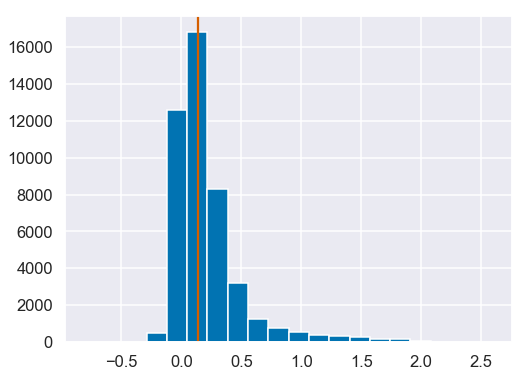

0.134560099548448 0.315796187021601


In [45]:
# scale residuals by daily weight, which sets many days to zero. 
w1 = np.diag(iterative_fitting.weights)
wres = np.dot(iterative_fitting.clear_sky_signals() - iterative_fitting.power_signals_d, w1)
use_days = np.logical_not(np.isclose(np.sum(wres, axis=0), 0))
scaled_wres = wres[:, use_days] / np.average(iterative_fitting.power_signals_d[:, use_days])
final_metric = scaled_wres[iterative_fitting.power_signals_d[:, use_days] > 1e-3]
plt.figure(figsize=(8,6))
plt.hist(final_metric, bins=20)
plt.axvline(np.percentile(final_metric, 50), color='r')
plt.show()
print(np.percentile(final_metric, 50), np.std(final_metric))

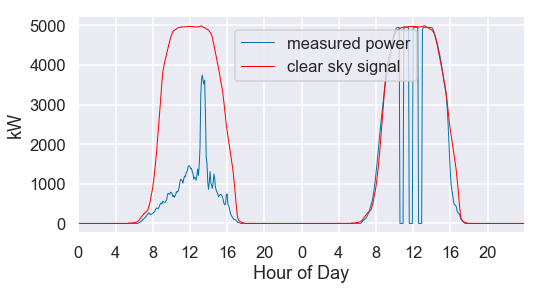

In [46]:
d1 = 570
d2 = d1 + 2
actual = iterative_fitting.power_signals_d[:, d1:d2].ravel(order='F')
clearsky = ((iterative_fitting.clear_sky_signals()))[:, d1:d2].ravel(order='F')
fig, ax = plt.subplots(nrows=1, figsize=(8,4))
ax.plot(actual, linewidth=1, label='measured power')
ax.plot(clearsky, linewidth=1, color='red', label='clear sky signal')
plt.legend(loc=(.35,.7))
ax.set_xlim(0, 288*(d2-d1))
ax.set_ylabel('kW')
ax.set_xticks(np.arange(0, 288*2, 2*24))
ax.set_xticklabels(np.tile(np.arange(0,24,4),2))
ax.set_xlabel('Hour of Day')
plt.show()

In [48]:
print(sum(iterative_fitting.l_cs_value.shape) + sum(iterative_fitting.r_cs_value.shape))

1751


(0, 1440)

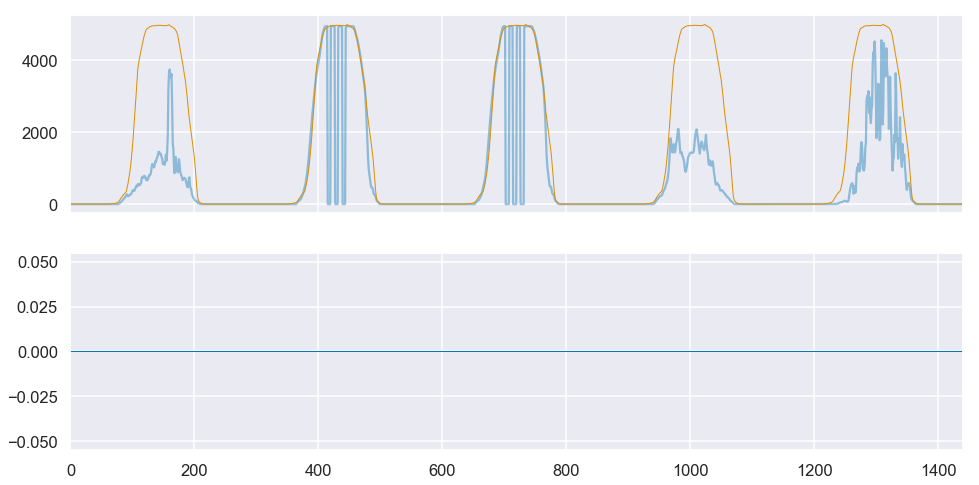

In [49]:
d1 = 570
d2 = d1+5
actual = iterative_fitting.power_signals_d[:, d1:d2].ravel(order='F')
clearsky = ((iterative_fitting.clear_sky_signals()))[:, d1:d2].ravel(order='F')
fig, ax = plt.subplots(nrows=2, figsize=(16,8), sharex=True)
ax[0].plot(actual, alpha=0.4)
ax[0].plot(clearsky, linewidth=1)
ax[1].plot(np.repeat(iterative_fitting.weights[d1:d2], 288), linewidth=1)
ax[1].set_xlim(0, 288*(d2-d1))

In [50]:
iterative_fitting.beta_value

array(-0.00131456)

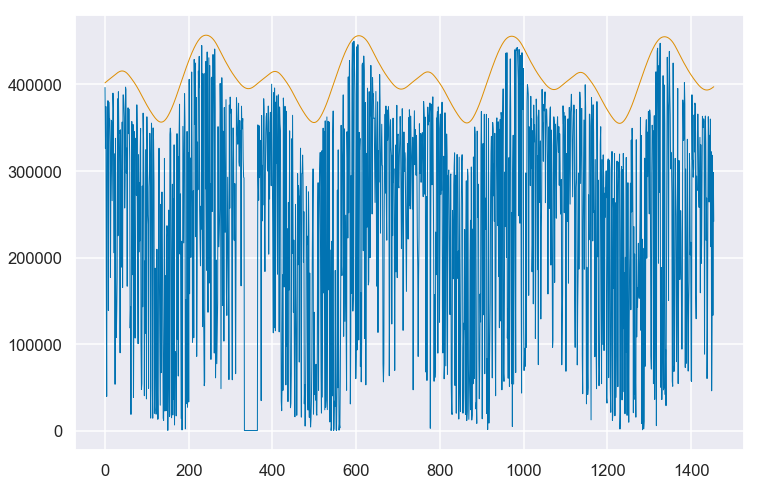

In [51]:
plt.figure(figsize=(12,8))
plt.plot(np.sum(power_signals_d, axis=0), linewidth=1)
plt.plot(iterative_fitting.r_cs_value[0] * np.sum(iterative_fitting.l_cs_value[:, 0]), linewidth=1)

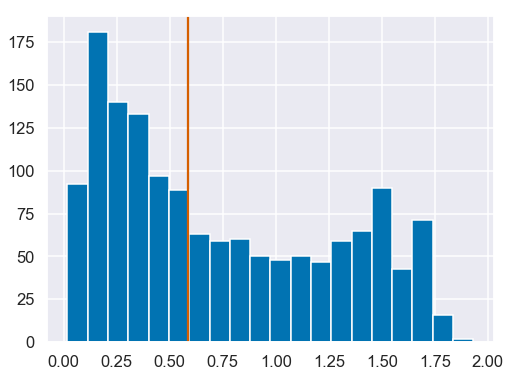

0.5875644005421612


In [52]:
residuals1 = (iterative_fitting.r_cs_value[0] * np.sum(iterative_fitting.l_cs_value[:, 0]) - np.sum(power_signals_d, axis=0)) / np.average(np.sum(power_signals_d, axis=0))
plt.figure(figsize=(8,6))
plt.hist(residuals1, bins=20)
plt.axvline(np.percentile(residuals1, 50), color='r')
plt.show()
print(np.percentile(residuals1, 50))

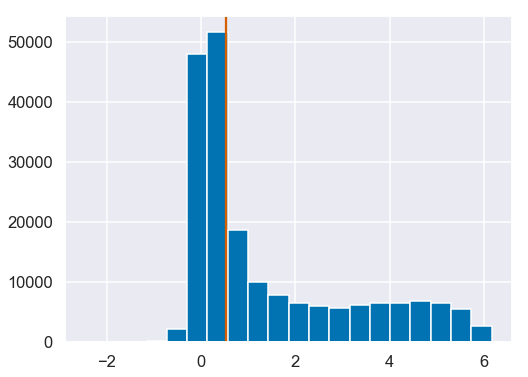

0.522713189628577


In [53]:
residuals2 = ((iterative_fitting.clear_sky_signals() - iterative_fitting.power_signals_d) / np.average(iterative_fitting.power_signals_d))[iterative_fitting.power_signals_d > 1e-3]
plt.figure(figsize=(8,6))
plt.hist(residuals2, bins=20)
plt.axvline(np.percentile(residuals2, 50), color='r')
plt.show()
print(np.percentile(residuals2, 50))

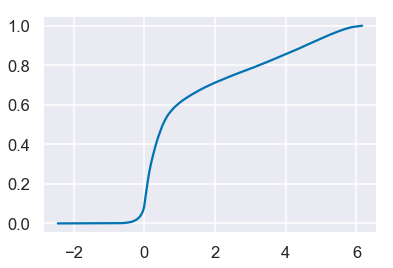

In [54]:
plt.plot(np.sort(residuals2), np.linspace(0, 1, len(residuals2), endpoint=False))

In [55]:
np.save('good_quantiles.npy', np.percentile(residuals2, np.arange(2, 99, 2)))

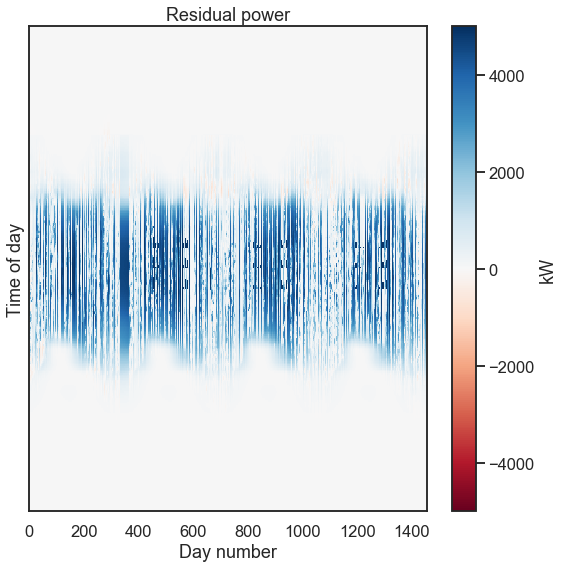

In [56]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=1, figsize=(8,8), sharex=True)
    r = iterative_fitting.clear_sky_signals() - iterative_fitting.power_signals_d
    val = np.max([np.abs(np.min(r)), np.abs(np.max(r))])
    foo = ax.imshow(r, cmap='RdBu', interpolation='none', aspect='auto', vmin=-val, vmax=val)
    #plt.colorbar(label='kW')
    ax.set_title('Residual power')
    plt.colorbar(foo, ax=ax, label='kW')
    ax.set_xlabel('Day number')
    ax.set_yticks([])
    ax.set_ylabel('Time of day')
    plt.tight_layout()

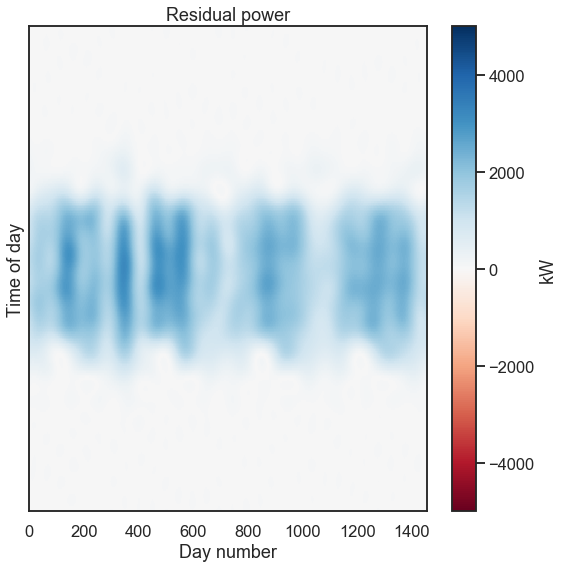

In [57]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=1, figsize=(8,8), sharex=True)
    r = iterative_fitting.clear_sky_signals() - iterative_fitting.power_signals_d
    val = np.max([np.abs(np.min(r)), np.abs(np.max(r))])
    foo = ax.imshow(lowpass_2d(r, r=15), cmap='RdBu', interpolation='none', aspect='auto', vmin=-val, vmax=val)
    #plt.colorbar(label='kW')
    ax.set_title('Residual power')
    plt.colorbar(foo, ax=ax, label='kW')
    ax.set_xlabel('Day number')
    ax.set_yticks([])
    ax.set_ylabel('Time of day')
    plt.tight_layout()

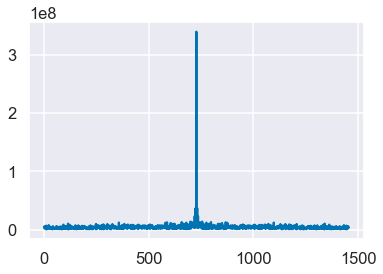

In [58]:
a = np.fft.fft2(iterative_fitting.power_signals_d)[0]
plt.plot(np.abs(np.fft.fftshift(a)))